# Planning Stage - Christin Wang #

In [43]:
library(MASS)
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(broom)
library(modelr)
library(gridExtra)
library(grid)

options(repr.plot.width = 15, repr.plot.height = 15) 

## I. Data Description ##

The Cleveland heart disease dataset, sourced from the UCI repository, was originally donated on 6/30/1988, contributed by A. Janosi, W. Steinbrunn, M. Pfisterer, R. Detrano, etc. It was collected from medical records for heart disease research. The primary use of this dataset is to distinguish between the presence (values 1, 2, 3, 4) and absence (value 0) of heart disease. For this project, we are going to use the Processed Cleveland data, containing 303 rows and 14 columns (extracted from a larger set of 76).


The dataset contains 13 attributes and a target variable, with 8 categorical variables and 5 numerical variables. The detailed description are as follows:
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. ca: number of major vessels (0-3) colored by fluoroscopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversible defect
14. num: diagnosis of heart disease
    - Value 0: absence
    - Value 1,2,3,4: presence


## II. Question ##

1. [Inference] Amongst the covariates, which are associated with heart disease?
2. [Prediction] Are we able to use the associated covariates to predict the probability of the presence of heart disease in a patient?

- The dataset contains 13 variables that are potential predictors of heart disease. By splitting the data into training and testing sets, selecting the input variables that provide the best goodness of fit, and performing hypothesis tests to determine which covariates are significantly related to heart disease, we can build a logistic regression model to predict the probability of a patient having heart disease.


## III. Exploratory Data Analysis and Visualization ##

### 1. Data preperation

- Read the csv file of `processed.cleveland.data`.
- Rename the column names of the dataset.
- Change the diagnosis presence values (1,2,3,4) all into 1.
- Mutate all catagorical variables into factors for coding convinience.
- Drop any NA values.

In [44]:
heart_data <- read_csv("https://raw.githubusercontent.com/Speculatorrr/STAT301/main/processed.cleveland.data?token=GHSAT0AAAAAACVKAVDCISXAPJBRTBVAWBUQZVEDPNQ", 
                        col_names = FALSE)
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol",
                            "fbs", "restecg", "thalach", "exang", "oldpeak",
                            "slope", "ca", "thal", "num")

categorical_vars <- c("sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal")

heart_data <- heart_data %>%
    mutate(num = if_else(num > 0, 1, 0)) %>%
    mutate(across(all_of(categorical_vars), as.factor),
    num = as.factor(num)) %>%
    drop_na()

head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### 2. Visualization



**[Graph1] Bar Chart of Categorical Variables Labeled by Heart Disease Diagnosis Results**

- This graph compares the frequencies of diagnosis results within 8 different categorical variables, and identifies which categorical variables are more strongly associated with heart disease. Making us better to understand the impact of each categorical variable on heart disease.

    In this case, we see that `cp`, `restecg`, `exang`, `slope`, `ca` and `thal` have a relatively stronger association with the presence of heart disease.

- I've also included a barchart for `num` counting the presence of heart disease to make sure that the classes are not imbalanced. Fortunately, they are balanced.


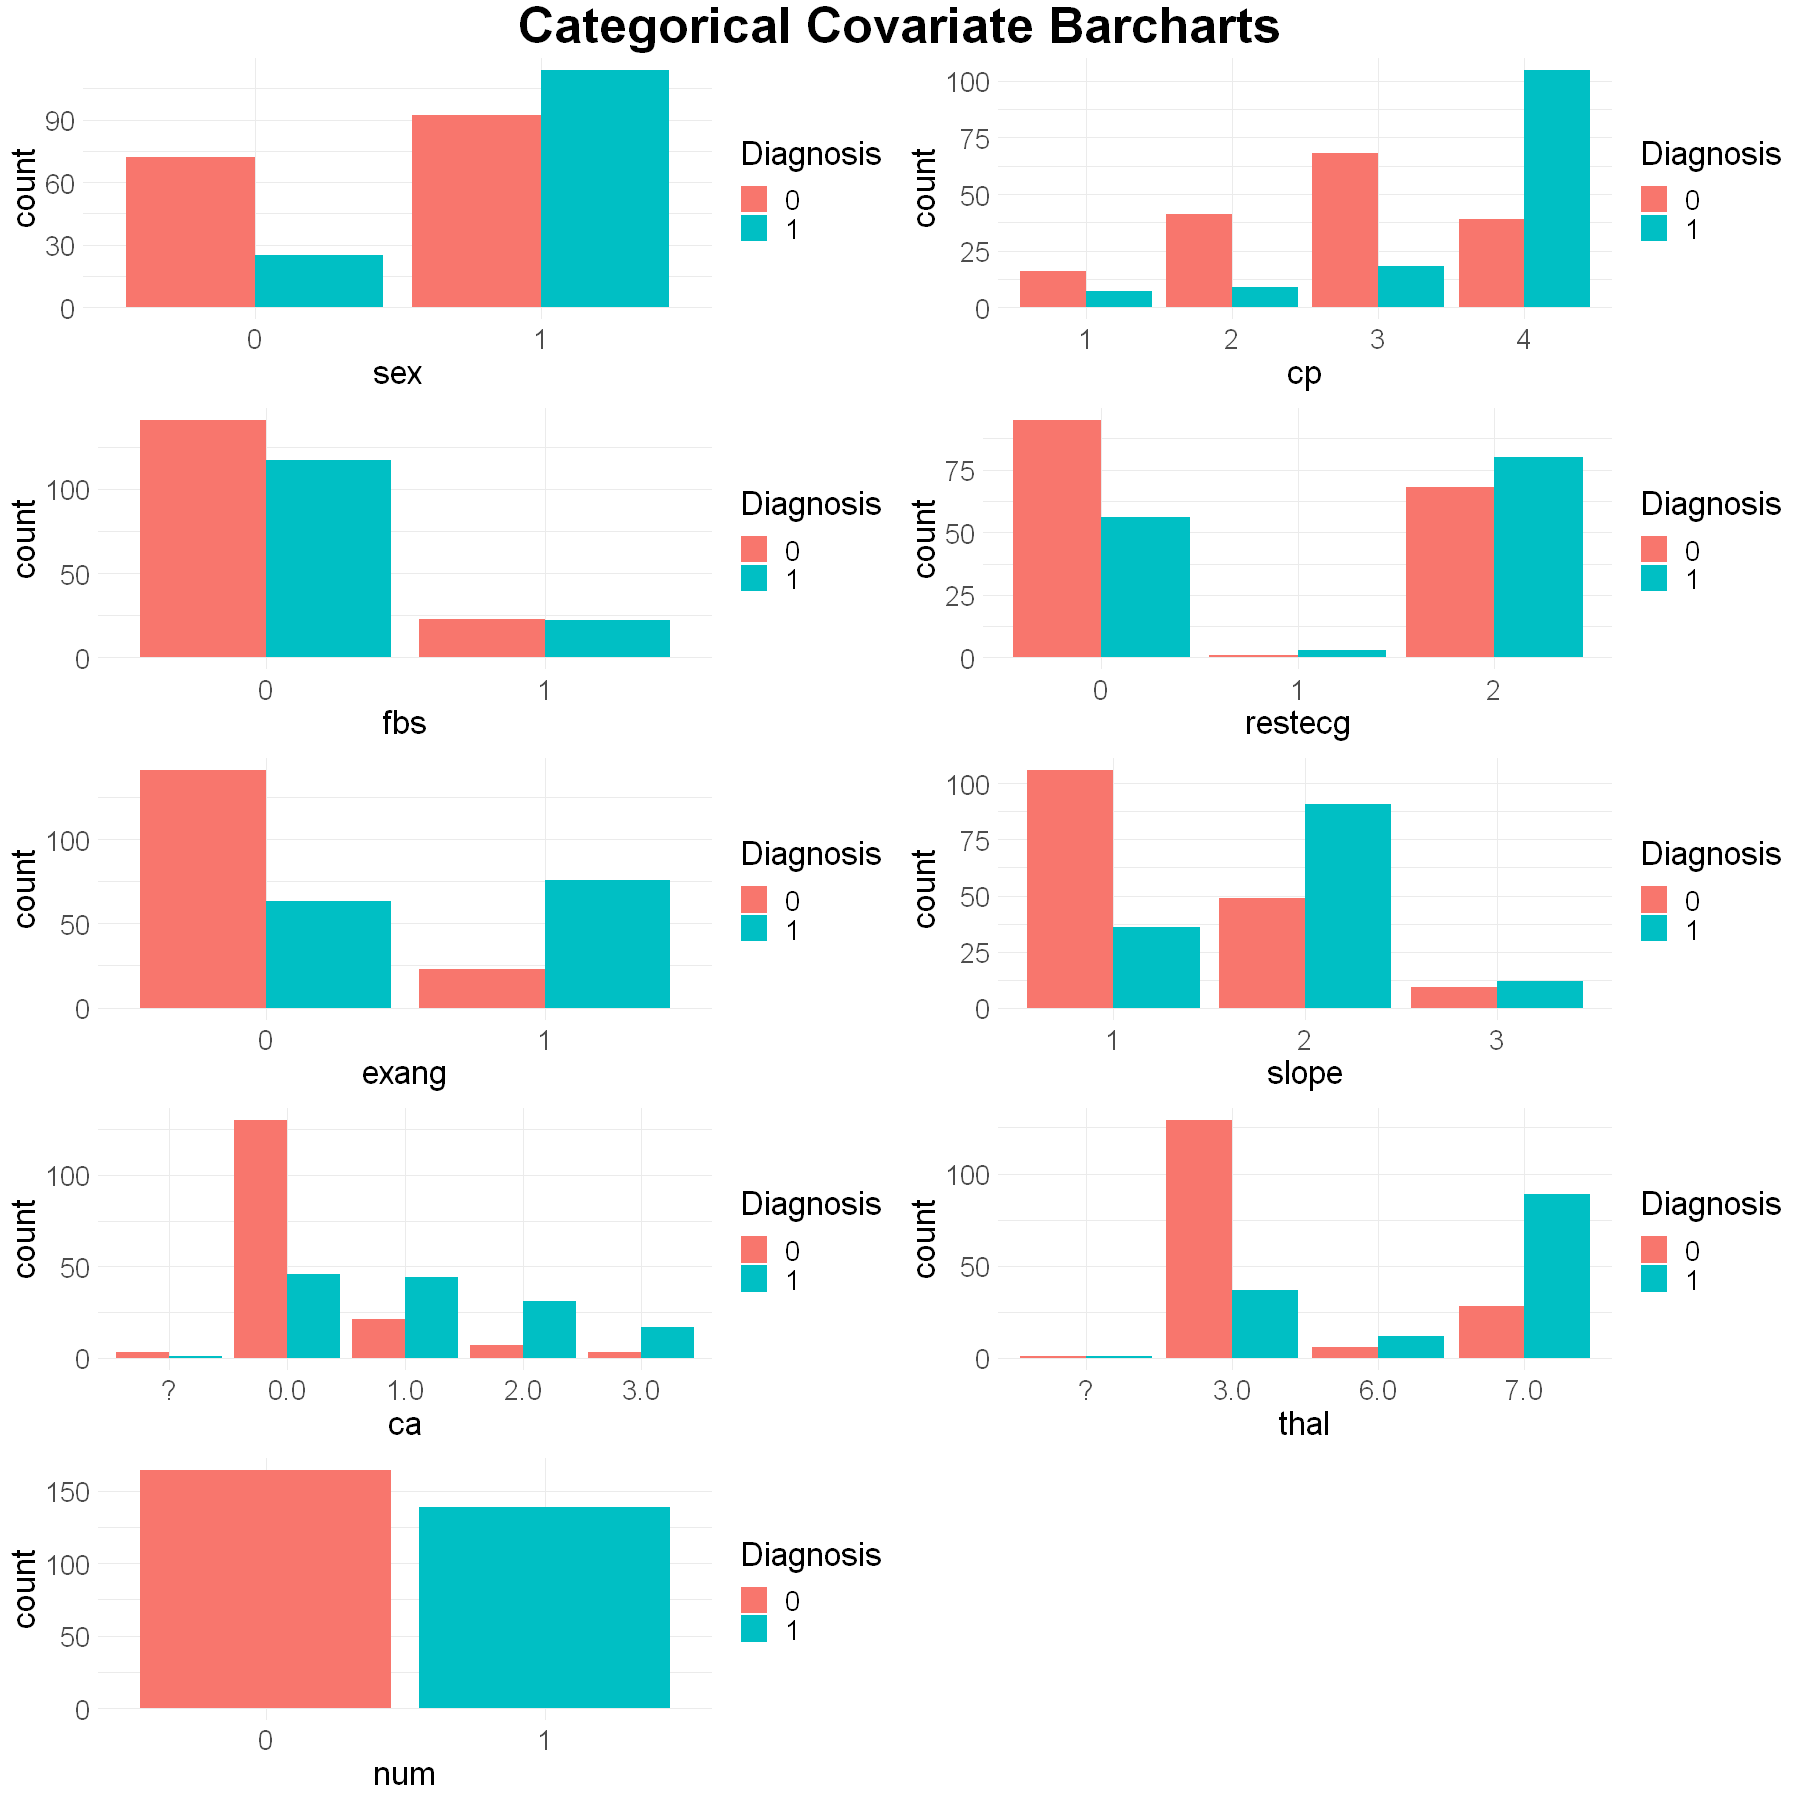

In [45]:
draw_bar_chart <- function(data, categorical_vars, num) {
  ggplot(data, aes_string(x = categorical_vars, fill = num)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    labs(x = categorical_vars, fill = "Diagnosis")
}

sex_bar <- draw_bar_chart(heart_data, "sex", "num")
cp_bar <- draw_bar_chart(heart_data, "cp", "num")
fbs_bar <- draw_bar_chart(heart_data, "fbs", "num")
restecg_bar <- draw_bar_chart(heart_data, "restecg", "num")
exang_bar <- draw_bar_chart(heart_data, "exang", "num")
slope_bar <- draw_bar_chart(heart_data, "slope", "num")
ca_bar <- draw_bar_chart(heart_data, "ca", "num")
thal_bar <- draw_bar_chart(heart_data, "thal", "num")
num_bar <- draw_bar_chart(heart_data, "num", "num")

grid.arrange(
  sex_bar, cp_bar, fbs_bar, restecg_bar,
  exang_bar, slope_bar, ca_bar, thal_bar, num_bar,
  ncol = 2,
  top = textGrob("Categorical Covariate Barcharts", gp = gpar(fontsize = 30, fontface = "bold"))
)

**[Graph2] `ggpairs` for Numerical Variables**

- By seeing how numerical variables interact with each other, it helps in detecting potential multicollinearity among the numerical variables.

    In this case, I see a positive relation between `chol`&`age`, `chol`&`thalach`, and a negative relation between `age`&`thalach`. So I assume these 3 pairs would have the strongest correlation.


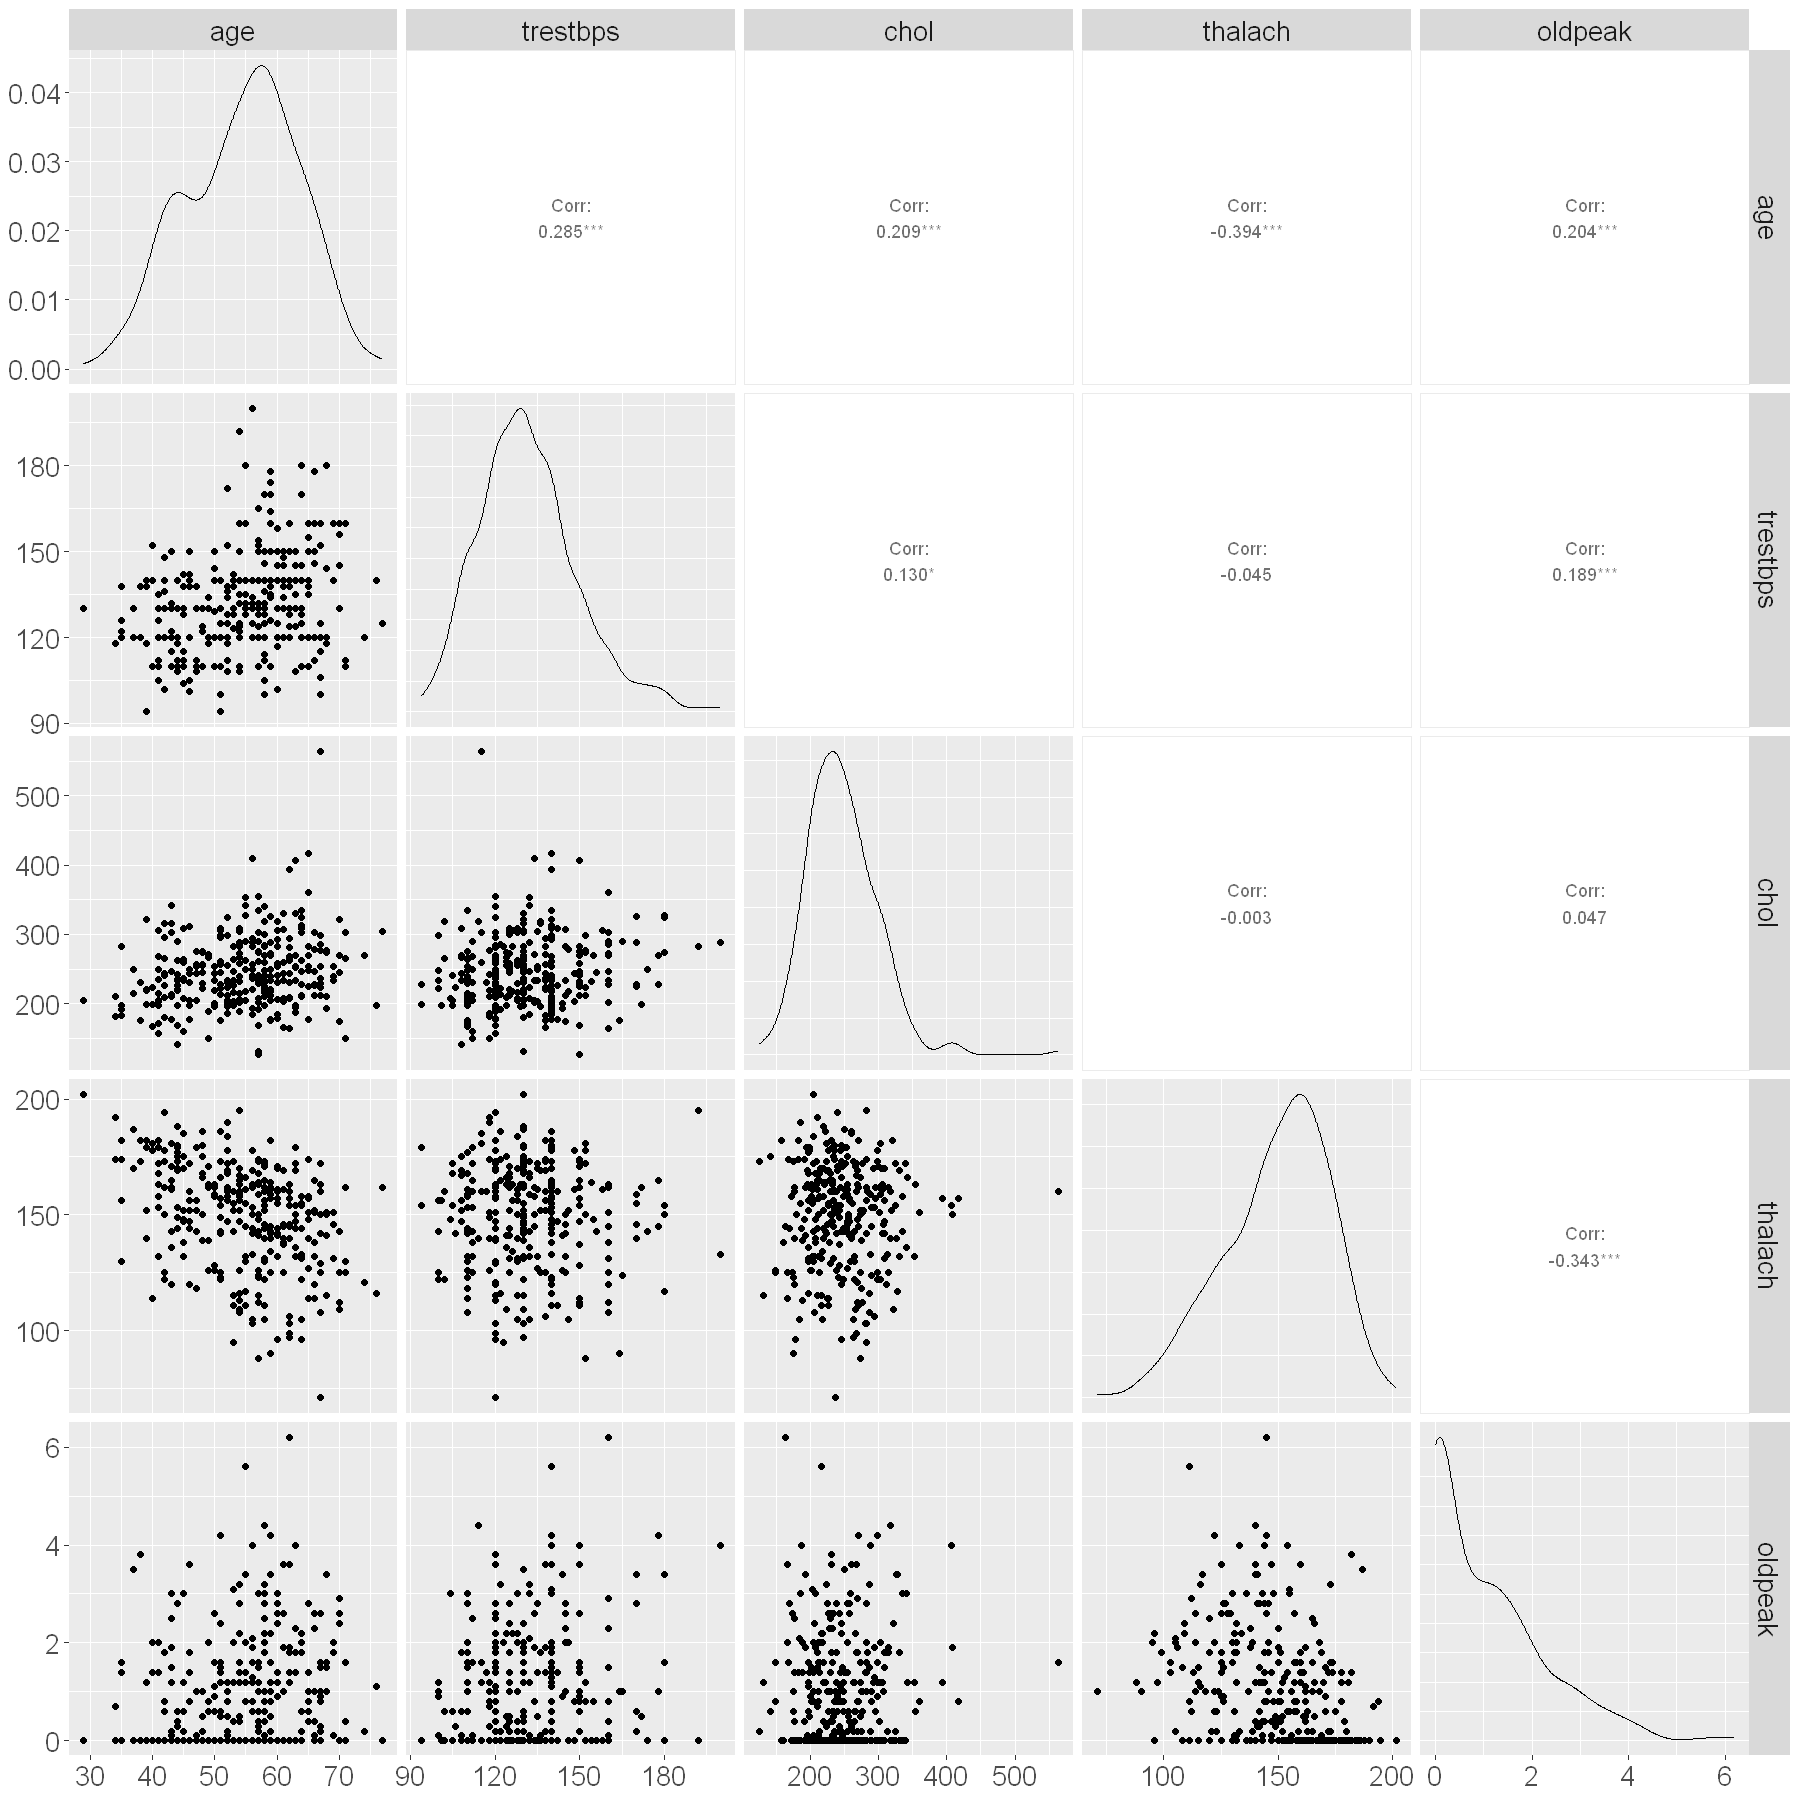

In [46]:
heart_pair <- 
    heart_data %>%
    select(-num, -categorical_vars) %>%
    ggpairs(progress = FALSE) +
    theme(text = element_text(size = 20))

heart_pair

**[Graph3] Correlation Matrix Heatmap of Numerical Variables**

- Similar but more accurate than `ggpairs`, by visualizing the pairwise correlations between numerical variables, this helps to identify the degree of association between variables and detect multicollinearity, which can insure the correctness of our prediction.

    Unlike the pairs (`chol`&`age`, `chol`&`thalach`, `age`&`thalach)` that I sense to have the strongest correlation from the `ggpairs` plot above. Within this heatmap, `trestbps`&`age`, `age`&`thalach`, `oldpeak`&`thalach` are shown to have the strongest correlation. So, we might want to put multicollinearity into concern for these variables, probably dropping one afterwards.
    


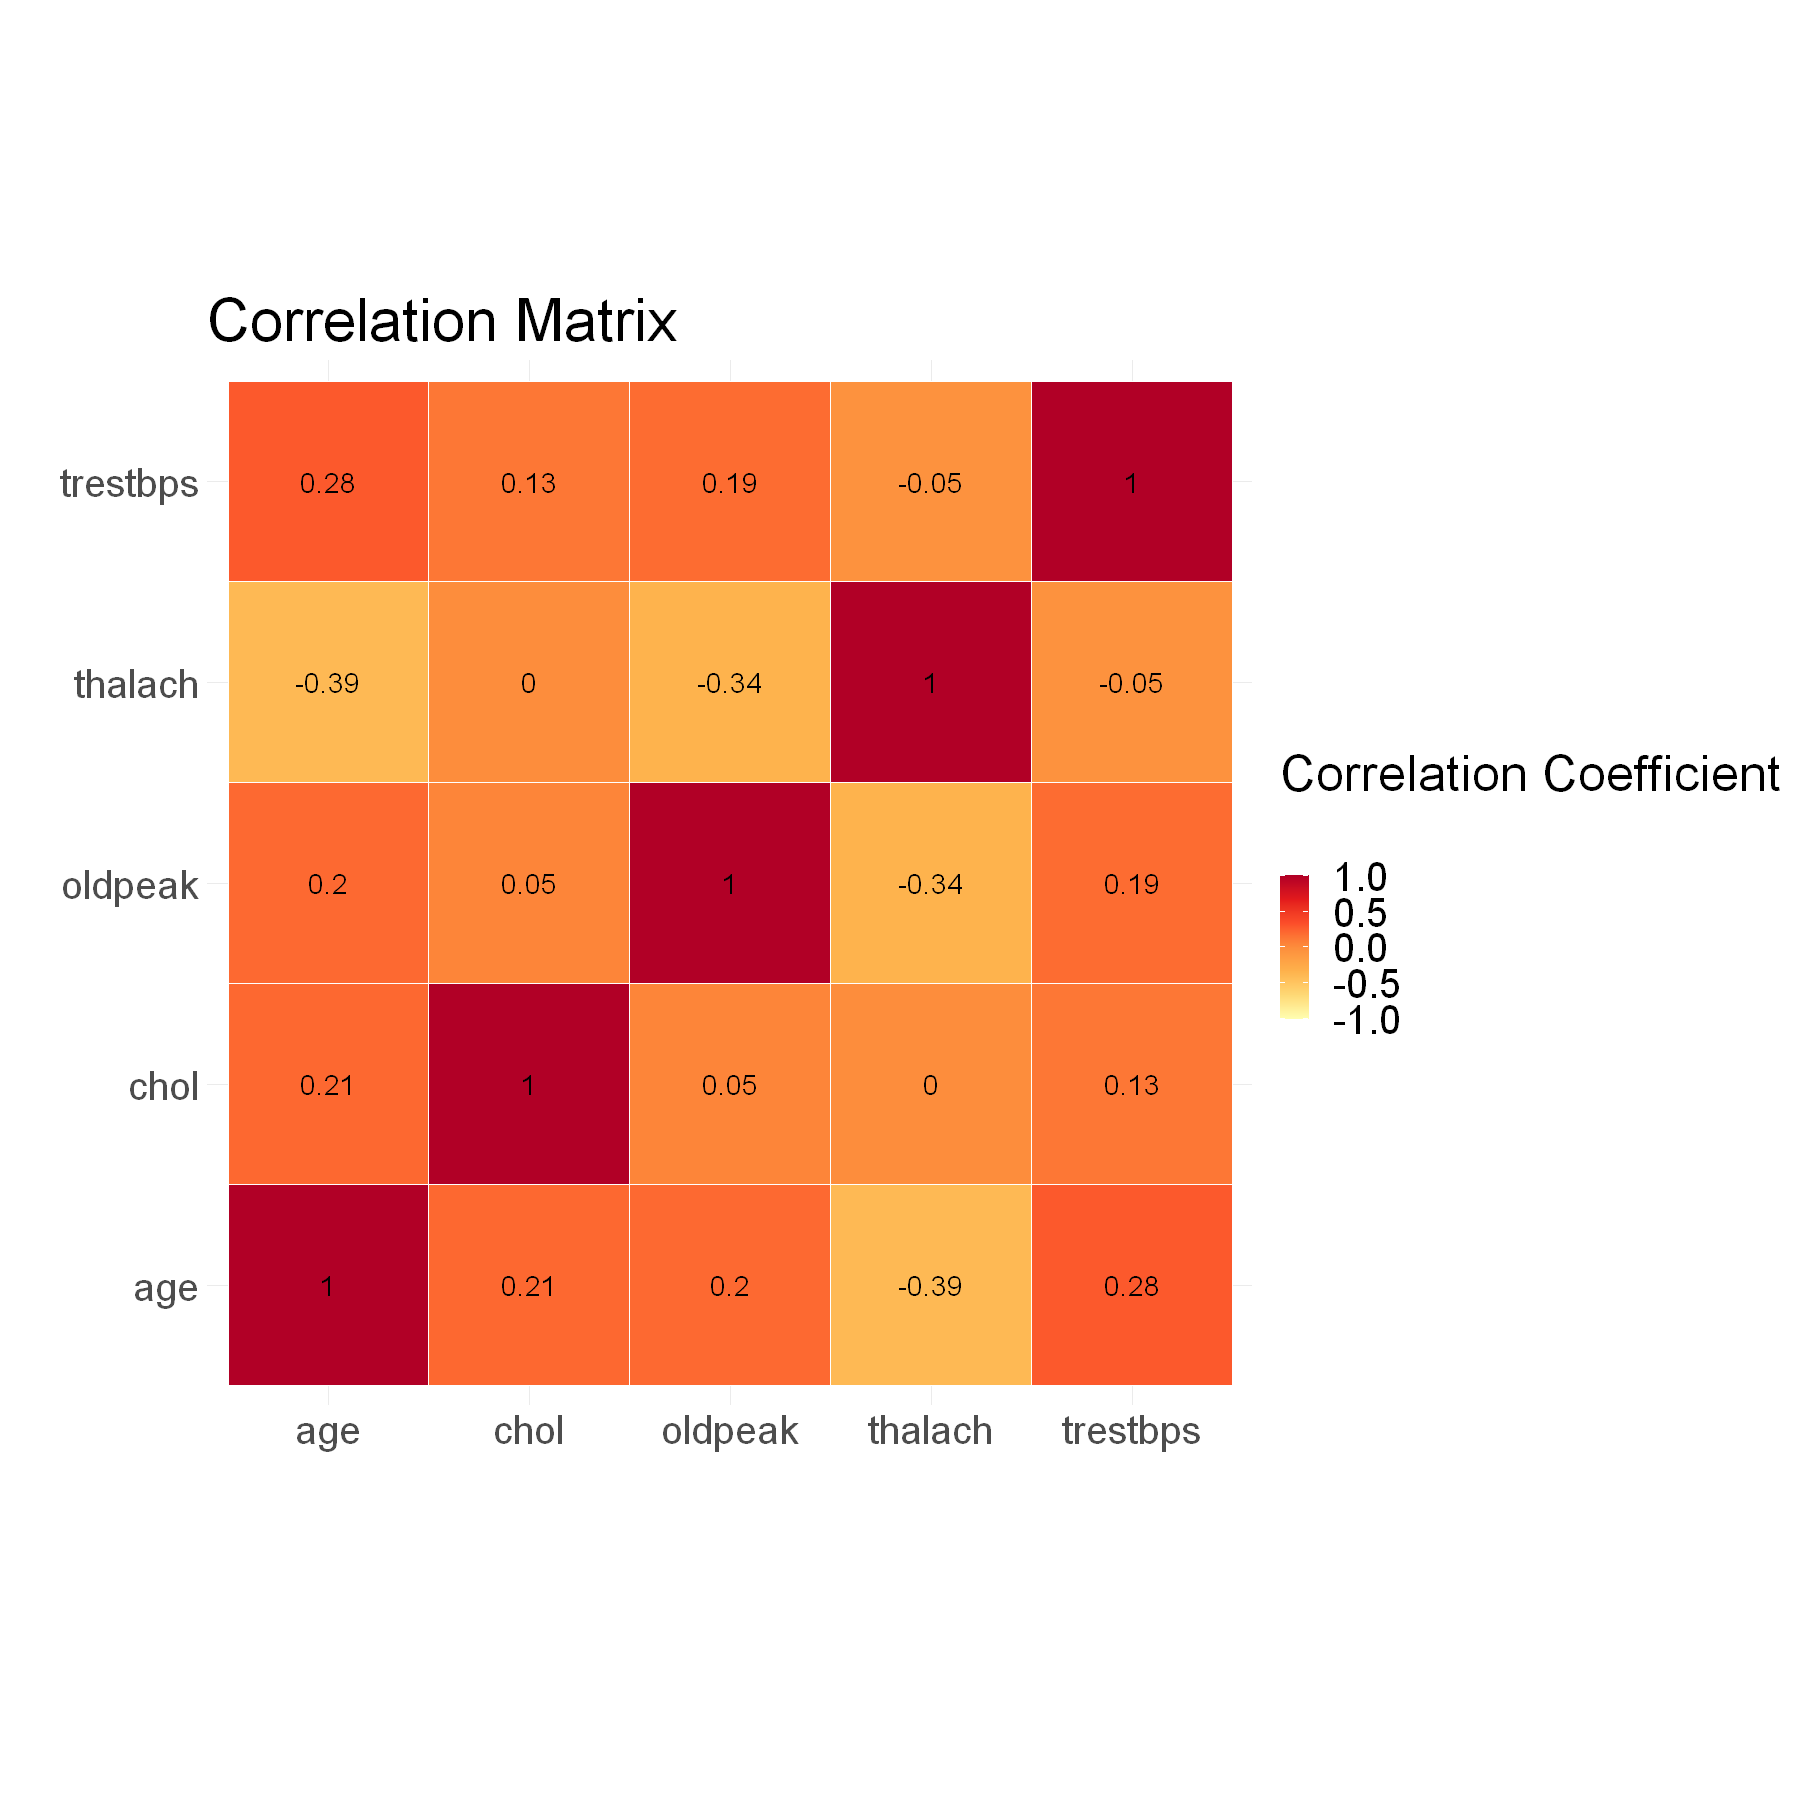

In [47]:
corr_matrix <- heart_data %>%
            select(-categorical_vars, -num) %>%
            cor() %>%
            as_tibble(rownames = 'var1') %>%
            pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix <- corr_matrix %>%
   ggplot(aes(var1, var2)) +
   geom_tile(aes(fill = corr), color = "white") +
   scale_fill_distiller("Correlation Coefficient \n",
       palette =  "YlOrRd",
       direction = 1, 
       limits = c(-1, 1)
     ) +
     labs(x = "", y = "") +
     theme_minimal() +
     theme(text = element_text(size = 30)) +
     coord_fixed() +
   geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6) +
   ggtitle("Correlation Matrix")

plot_corr_matrix

**[Graph4] Boxplots Comparing Heart Disease Diagnosis between Numerical Variables**

- By illustrating the distribution of numerical variables grouped by heart disease diagnosis, we can easily see the differences in the distribution of values, including the presence of outliers, mean, median and variability. Comparing these can help us identify which variables are more influential in predicting heart disease.

    We will compare the median since the mean may be affected by outliers.
    In this case, we see that `age`, `oldpeak` and `thalach` has a relatively big differences between diagnosis results. Thus, would be more useful in the prediction model.


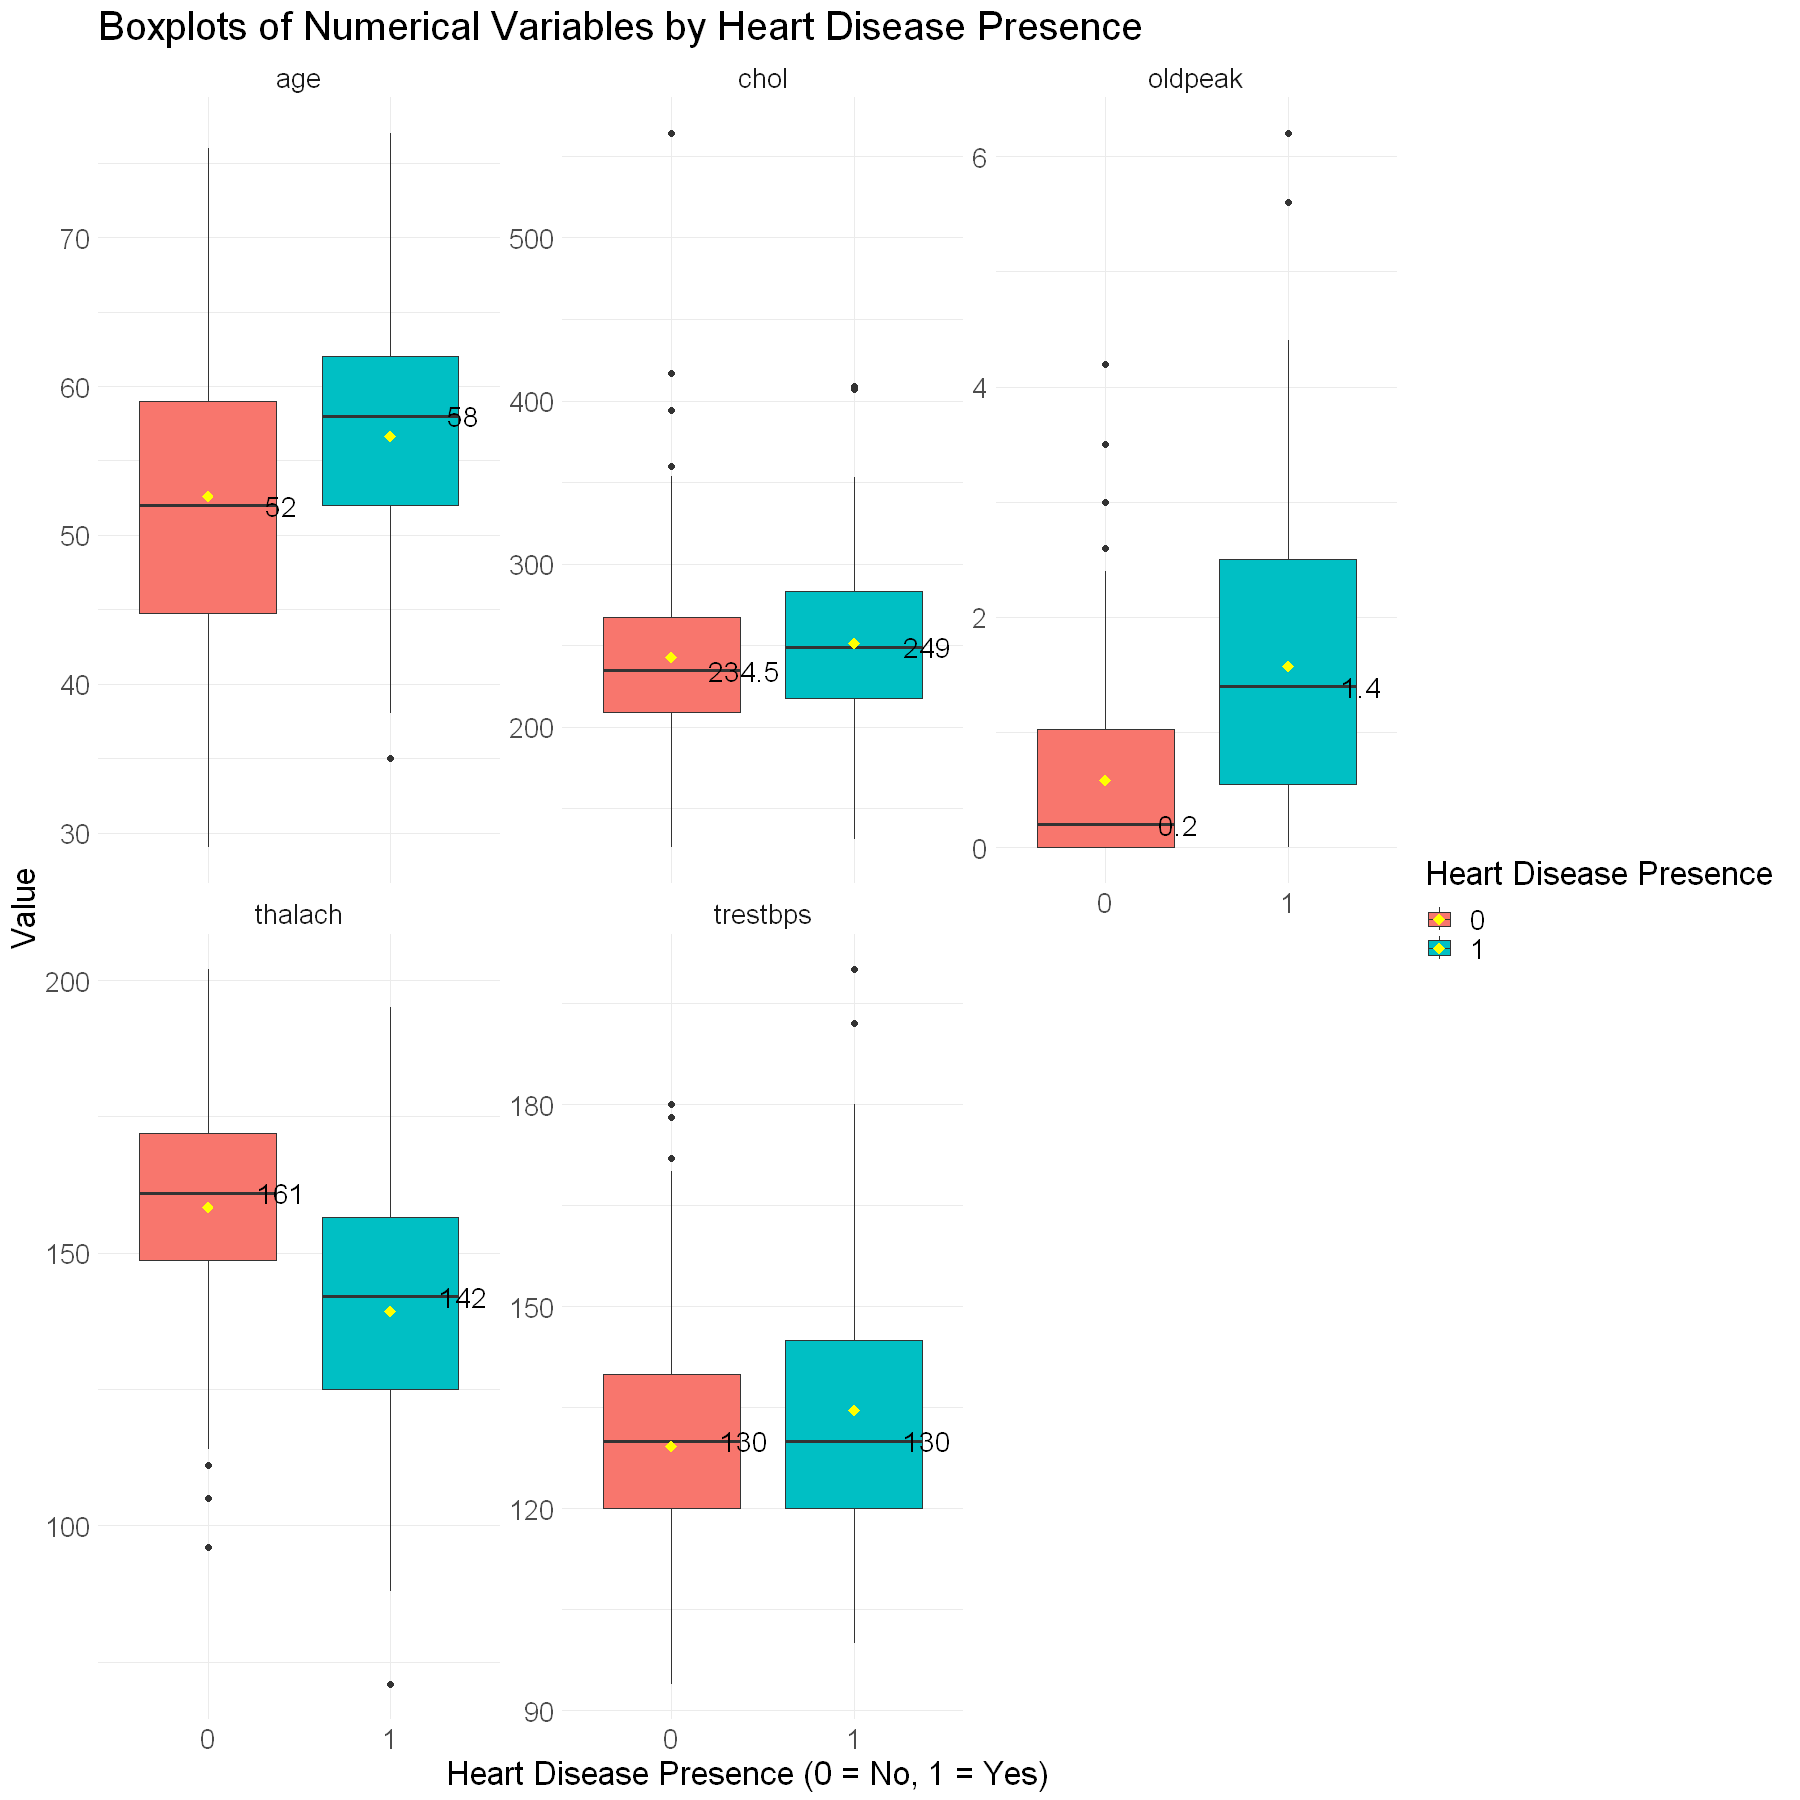

In [48]:
heart_long <- heart_data %>%
  select(- categorical_vars) %>%
  pivot_longer(cols = -num , names_to = "variable", values_to = "value")

heart_boxplot <- heart_long %>%
  ggplot(aes(x = as.factor(num), y = value, fill = as.factor(num))) +
  geom_boxplot() +
  stat_summary(aes(label = round(..y.., 2)),
               fun = median,
               geom = "text",
               position = position_nudge(x = 0.4, y = 0),
               size = 6) +
  facet_wrap(~ variable, scales = "free_y") +
  stat_summary(aes(as.factor(num), value, fill = as.factor(num)),
               fun = mean,
               colour = "yellow",
               geom = "point",
               shape = 18,
               size = 3) +
  theme_minimal() +
  theme(text = element_text(size = 20)) +
  labs(title = "Boxplots of Numerical Variables by Heart Disease Presence", 
       x = "Heart Disease Presence (0 = No, 1 = Yes)", y = "Value") +
  scale_fill_discrete(name = "Heart Disease Presence")
heart_boxplot

**Visualization Conclusion**

After looking into the 4 graphs, we get a comprehensive overview of the data. At this point, I assume that `age`, `oldpeak`, `thalach`, `cp`, `restecg`, `exang`, `slope`, `ca` and `thal`, these 9 covariates are more relevant to heart disease diagnosis. Additionally, there may be multicollinearity amongst the variables `trestbps`,`age`, `thalach` and `oldpeak`.

## IV. Methods and Plan ##

- Since the response variable is a binary one, I attempt to use logistic regression to make a model and predict the probability of  heart disease presence.

- Attempted procedures:

    0. Data preperation and general interpretation.
    1. Split data into train & test.
    2. Fit the full Logistic Regression model by train. Then use model to calculate test RMSE.
    3. Make a forward selection. Out of the 13 models, select the best one in terms of its goodness of fit (smallest 𝐶_𝑝).
    4. Fit the reduced Logistic Regression model using train. Then use model to calculate test RMSE.
    5. Compare the test RMSE between full&reduced model, pick the model with smaller RMSE.
    6. Tidy the results of the chosen model, interpret coefficients, p-values, confidence intervals.
    7. Use final chosen model to predict the heart disease probability of a given patient.


- We need to make 4 assumptions:
    1. Linearity of Logits
    2. Independence Identical Distribution of Errors terms (including constant variation)
    3. Normailty of Errors
    4. No collinearity


- The potential weaknesses may include:
    - Difficulty of interpretation compared to linear regression.
    - Failed to detect cofounders, causing false accuracy.
    - Overfitting.
    - Results influenced by strong outliers.
    - Due to assumption of logit being linearary, non linear problems can't be solved with this.
